# Challenge #13: Benchmarking Different SAXPY Problem Sizes

This challenge focuses on benchmarking the performance of a simple CUDA program (saxpy) across varying problem sizes. The goal is to observe how execution time scales as the input size increases and to gain hands-on experience profiling CUDA programs.

In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Fri Apr 25 06:17:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8       

## Implementation Details

### To begin, I used Claude AI to help modify the official SAXPY example from NVIDIA’s CUDA C tutorial. I asked it to:
`Modify the program to run for powers of two from 2^15 to 2^29, and include execution time measurement`

The output code was clean and measured only GPU kernel execution time using std::chrono; synchronized with cudaDeviceSynchronize() to ensure accurate timing.


In [2]:
code = r"""
#include <stdio.h>
#include <math.h>
#include <chrono>
using namespace std::chrono;

__global__
void saxpy(int n, float a, float *x, float *y)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = a * x[i] + y[i];
}

int main(void)
{
    for (int power = 15; power <= 29; power++) {
        int N = 1 << power;
        float *x, *y, *d_x, *d_y;

        x = (float*)malloc(N * sizeof(float));
        y = (float*)malloc(N * sizeof(float));

        cudaMalloc(&d_x, N * sizeof(float));
        cudaMalloc(&d_y, N * sizeof(float));

        for (int i = 0; i < N; i++) {
            x[i] = 1.0f;
            y[i] = 2.0f;
        }

        cudaMemcpy(d_x, x, N * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_y, y, N * sizeof(float), cudaMemcpyHostToDevice);

        // 🔹 Start timing
        auto start = high_resolution_clock::now();

        saxpy<<<(N + 255) / 256, 256>>>(N, 2.0f, d_x, d_y);
        cudaDeviceSynchronize();  // Ensure kernel completes

        // 🔹 End timing
        auto end = high_resolution_clock::now();
        auto duration = duration_cast<microseconds>(end - start);
        printf("N = %d\tTime = %ld microseconds\n", N, duration.count());

        cudaMemcpy(y, d_y, N * sizeof(float), cudaMemcpyDeviceToHost);

        // Optional: verify correctness
        float maxError = 0.0f;
        for (int i = 0; i < N; i++)
            maxError = fmax(maxError, fabs(y[i] - 4.0f));
        printf("Max error: %f\n\n", maxError);

        // Clean up
        cudaFree(d_x);
        cudaFree(d_y);
        free(x);
        free(y);
    }

    return 0;
}

"""

with open("saxpy.cu", "w") as f:
    f.write(code)

In [3]:
# Compile and run
!nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 saxpy.cu -o saxpy
!./saxpy

N = 32768	Time = 162 microseconds
Max error: 0.000000

N = 65536	Time = 39 microseconds
Max error: 0.000000

N = 131072	Time = 58 microseconds
Max error: 0.000000

N = 262144	Time = 105 microseconds
Max error: 0.000000

N = 524288	Time = 113 microseconds
Max error: 0.000000

N = 1048576	Time = 136 microseconds
Max error: 0.000000

N = 2097152	Time = 186 microseconds
Max error: 0.000000

N = 4194304	Time = 281 microseconds
Max error: 0.000000

N = 8388608	Time = 462 microseconds
Max error: 0.000000

N = 16777216	Time = 843 microseconds
Max error: 0.000000

N = 33554432	Time = 1604 microseconds
Max error: 0.000000

N = 67108864	Time = 3117 microseconds
Max error: 0.000000

N = 134217728	Time = 6152 microseconds
Max error: 0.000000

N = 268435456	Time = 12220 microseconds
Max error: 0.000000

N = 536870912	Time = 24385 microseconds
Max error: 0.000000



###  Results
Execution Time vs Size

These charts show how kernel time increases with matrix size:

- Left: regular scale

- Right: log scale for a clearer trend

We can observe that time goes up as expected, especially at the higher sizes

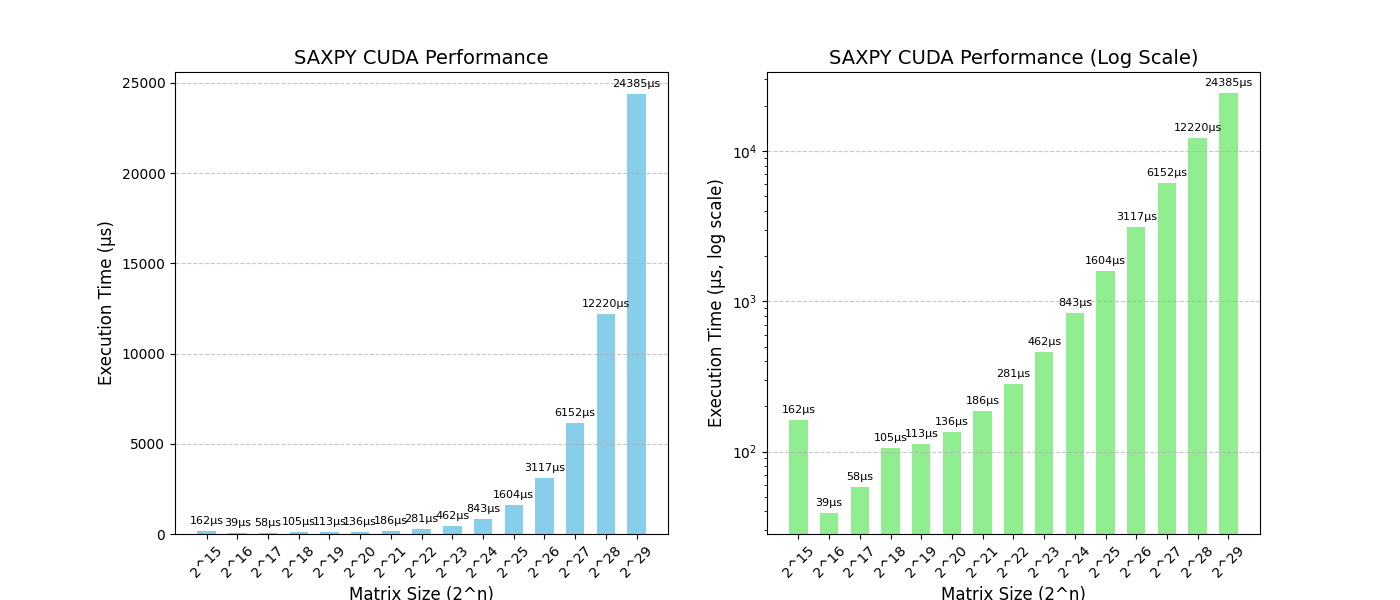


Time per Element (Efficiency)

This plot shows how much time the kernel takes per element:

Observations:

Super inefficient at small sizes (not enough work for the GPU)

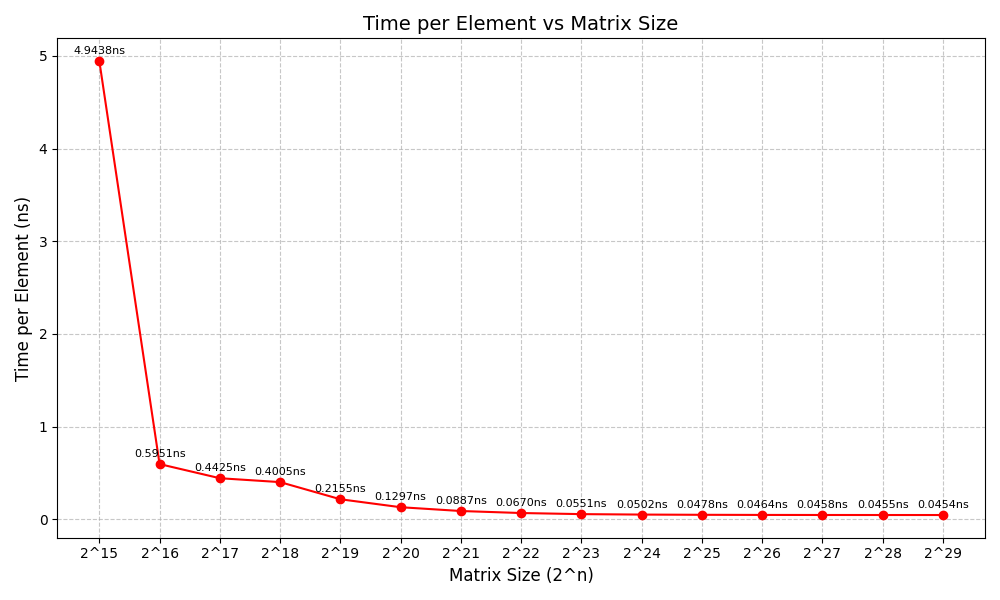

### Analysis

This benchmark shows a pretty typical performance curve for GPU workloads like SAXPY:

At smaller sizes (up to 2^20), the GPU isn’t fully utilized. We can observe this in the high time-per-element values — the overhead of launching the kernel and managing threads outweighs the benefits of parallelism.

From 2^21 onward, the GPU hits its stride. The time per element drops sharply and then flattens out around 0.045ns — a good indicator that the GPU is fully saturated and working efficiently.



## Advanced Timing Breakdown with cudaEvent

To get a deeper look at GPU performance, I modified the SAXPY program using cudaEvent_t to measure specific parts of the GPU workflow:

- Host to Device (H2D) Transfer

- Kernel Execution

- Device to Host (D2H) Transfer

- Total Execution Time (including allocations)

- CPU-side memory allocation timing

Claude helped generate this version using CUDA events (cudaEventRecord, cudaEventElapsedTime) for GPU timing, and std::chrono for CPU-side total time and memory allocations.


In [4]:
code = r"""
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <math.h>
#include <chrono>
using namespace std::chrono;

__global__
void saxpy(int n, float a, float *x, float *y) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n)
        y[i] = a * x[i] + y[i];
}

int main(void)
{
    for (int power = 15; power <= 25; power++) {
        int N = 1 << power;
        float *x, *y, *d_x, *d_y;

        // --- Start total time ---
        auto total_start = high_resolution_clock::now();

        // --- Allocation timing ---
        auto alloc_start = high_resolution_clock::now();
        x = (float*)malloc(N * sizeof(float));
        y = (float*)malloc(N * sizeof(float));
        cudaMalloc(&d_x, N * sizeof(float));
        cudaMalloc(&d_y, N * sizeof(float));
        auto alloc_end = high_resolution_clock::now();

        // Initialize host arrays
        for (int i = 0; i < N; i++) {
            x[i] = 1.0f;
            y[i] = 2.0f;
        }

        // --- H2D timing ---
        cudaEvent_t h2d_start, h2d_stop;
        cudaEventCreate(&h2d_start);
        cudaEventCreate(&h2d_stop);
        cudaEventRecord(h2d_start);
        cudaMemcpy(d_x, x, N * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_y, y, N * sizeof(float), cudaMemcpyHostToDevice);
        cudaEventRecord(h2d_stop);
        cudaEventSynchronize(h2d_stop);

        // --- Kernel timing ---
        cudaEvent_t kernel_start, kernel_stop;
        cudaEventCreate(&kernel_start);
        cudaEventCreate(&kernel_stop);
        cudaEventRecord(kernel_start);
        saxpy<<<(N + 255) / 256, 256>>>(N, 2.0f, d_x, d_y);
        cudaEventRecord(kernel_stop);
        cudaEventSynchronize(kernel_stop);

        // --- D2H timing ---
        cudaEvent_t d2h_start, d2h_stop;
        cudaEventCreate(&d2h_start);
        cudaEventCreate(&d2h_stop);
        cudaEventRecord(d2h_start);
        cudaMemcpy(y, d_y, N * sizeof(float), cudaMemcpyDeviceToHost);
        cudaEventRecord(d2h_stop);
        cudaEventSynchronize(d2h_stop);

        // --- End total time ---
        auto total_end = high_resolution_clock::now();

        // --- Timing calculations ---
        auto alloc_time = duration_cast<microseconds>(alloc_end - alloc_start).count();
        auto total_time = duration_cast<microseconds>(total_end - total_start).count();
        float h2d_ms, kernel_ms, d2h_ms;
        cudaEventElapsedTime(&h2d_ms, h2d_start, h2d_stop);
        cudaEventElapsedTime(&kernel_ms, kernel_start, kernel_stop);
        cudaEventElapsedTime(&d2h_ms, d2h_start, d2h_stop);

        // Convert CUDA event times from ms to microseconds
        float h2d_us = h2d_ms * 1000.0f;
        float kernel_us = kernel_ms * 1000.0f;
        float d2h_us = d2h_ms * 1000.0f;

        // --- Max error check ---
        float maxError = 0.0f;
        for (int i = 0; i < N; i++) {
            maxError = fmax(maxError, fabs(y[i] - 4.0f));
        }

        // --- Print results ---
        printf("N = %d\n", N);
        printf("Alloc time         = %ld us\n", alloc_time);
        printf("H2D memcpy time    = %.3f us\n", h2d_us);
        printf("Kernel time        = %.3f us\n", kernel_us);
        printf("D2H memcpy time    = %.3f us\n", d2h_us);
        printf("Total execution    = %ld us\n", total_time);
        printf("Max error          = %f\n\n", maxError);

        // --- Cleanup ---
        cudaFree(d_x);
        cudaFree(d_y);
        free(x);
        free(y);

        // Destroy events
        cudaEventDestroy(h2d_start); cudaEventDestroy(h2d_stop);
        cudaEventDestroy(kernel_start); cudaEventDestroy(kernel_stop);
        cudaEventDestroy(d2h_start); cudaEventDestroy(d2h_stop);
    }

    return 0;
}
"""

with open("saxpy_time.cu", "w") as f:
    f.write(code)


In [5]:
# Compile and run
!nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 saxpy_time.cu -o saxpy_time
!./saxpy_time

N = 32768
Alloc time         = 102692 us
H2D memcpy time    = 119.680 us
Kernel time        = 97.600 us
D2H memcpy time    = 51.424 us
Total execution    = 104202 us
Max error          = 0.000000

N = 65536
Alloc time         = 112 us
H2D memcpy time    = 170.080 us
Kernel time        = 15.968 us
D2H memcpy time    = 93.184 us
Total execution    = 786 us
Max error          = 0.000000

N = 131072
Alloc time         = 87 us
H2D memcpy time    = 335.648 us
Kernel time        = 15.264 us
D2H memcpy time    = 153.056 us
Total execution    = 1212 us
Max error          = 0.000000

N = 262144
Alloc time         = 95 us
H2D memcpy time    = 640.320 us
Kernel time        = 19.552 us
D2H memcpy time    = 276.128 us
Total execution    = 2644 us
Max error          = 0.000000

N = 524288
Alloc time         = 156 us
H2D memcpy time    = 1023.328 us
Kernel time        = 25.504 us
D2H memcpy time    = 454.304 us
Total execution    = 4056 us
Max error          = 0.000000

N = 1048576
Alloc time         

### Execution Breakdown (Log-Scale)

This plot shows how each part of execution scales as 𝑁 increases:

- Memory transfers (H2D + D2H) grow faster than kernel time.

- Kernel time stays relatively small compared to the rest.

- Total execution time is increasingly dominated by data movement, not computation.

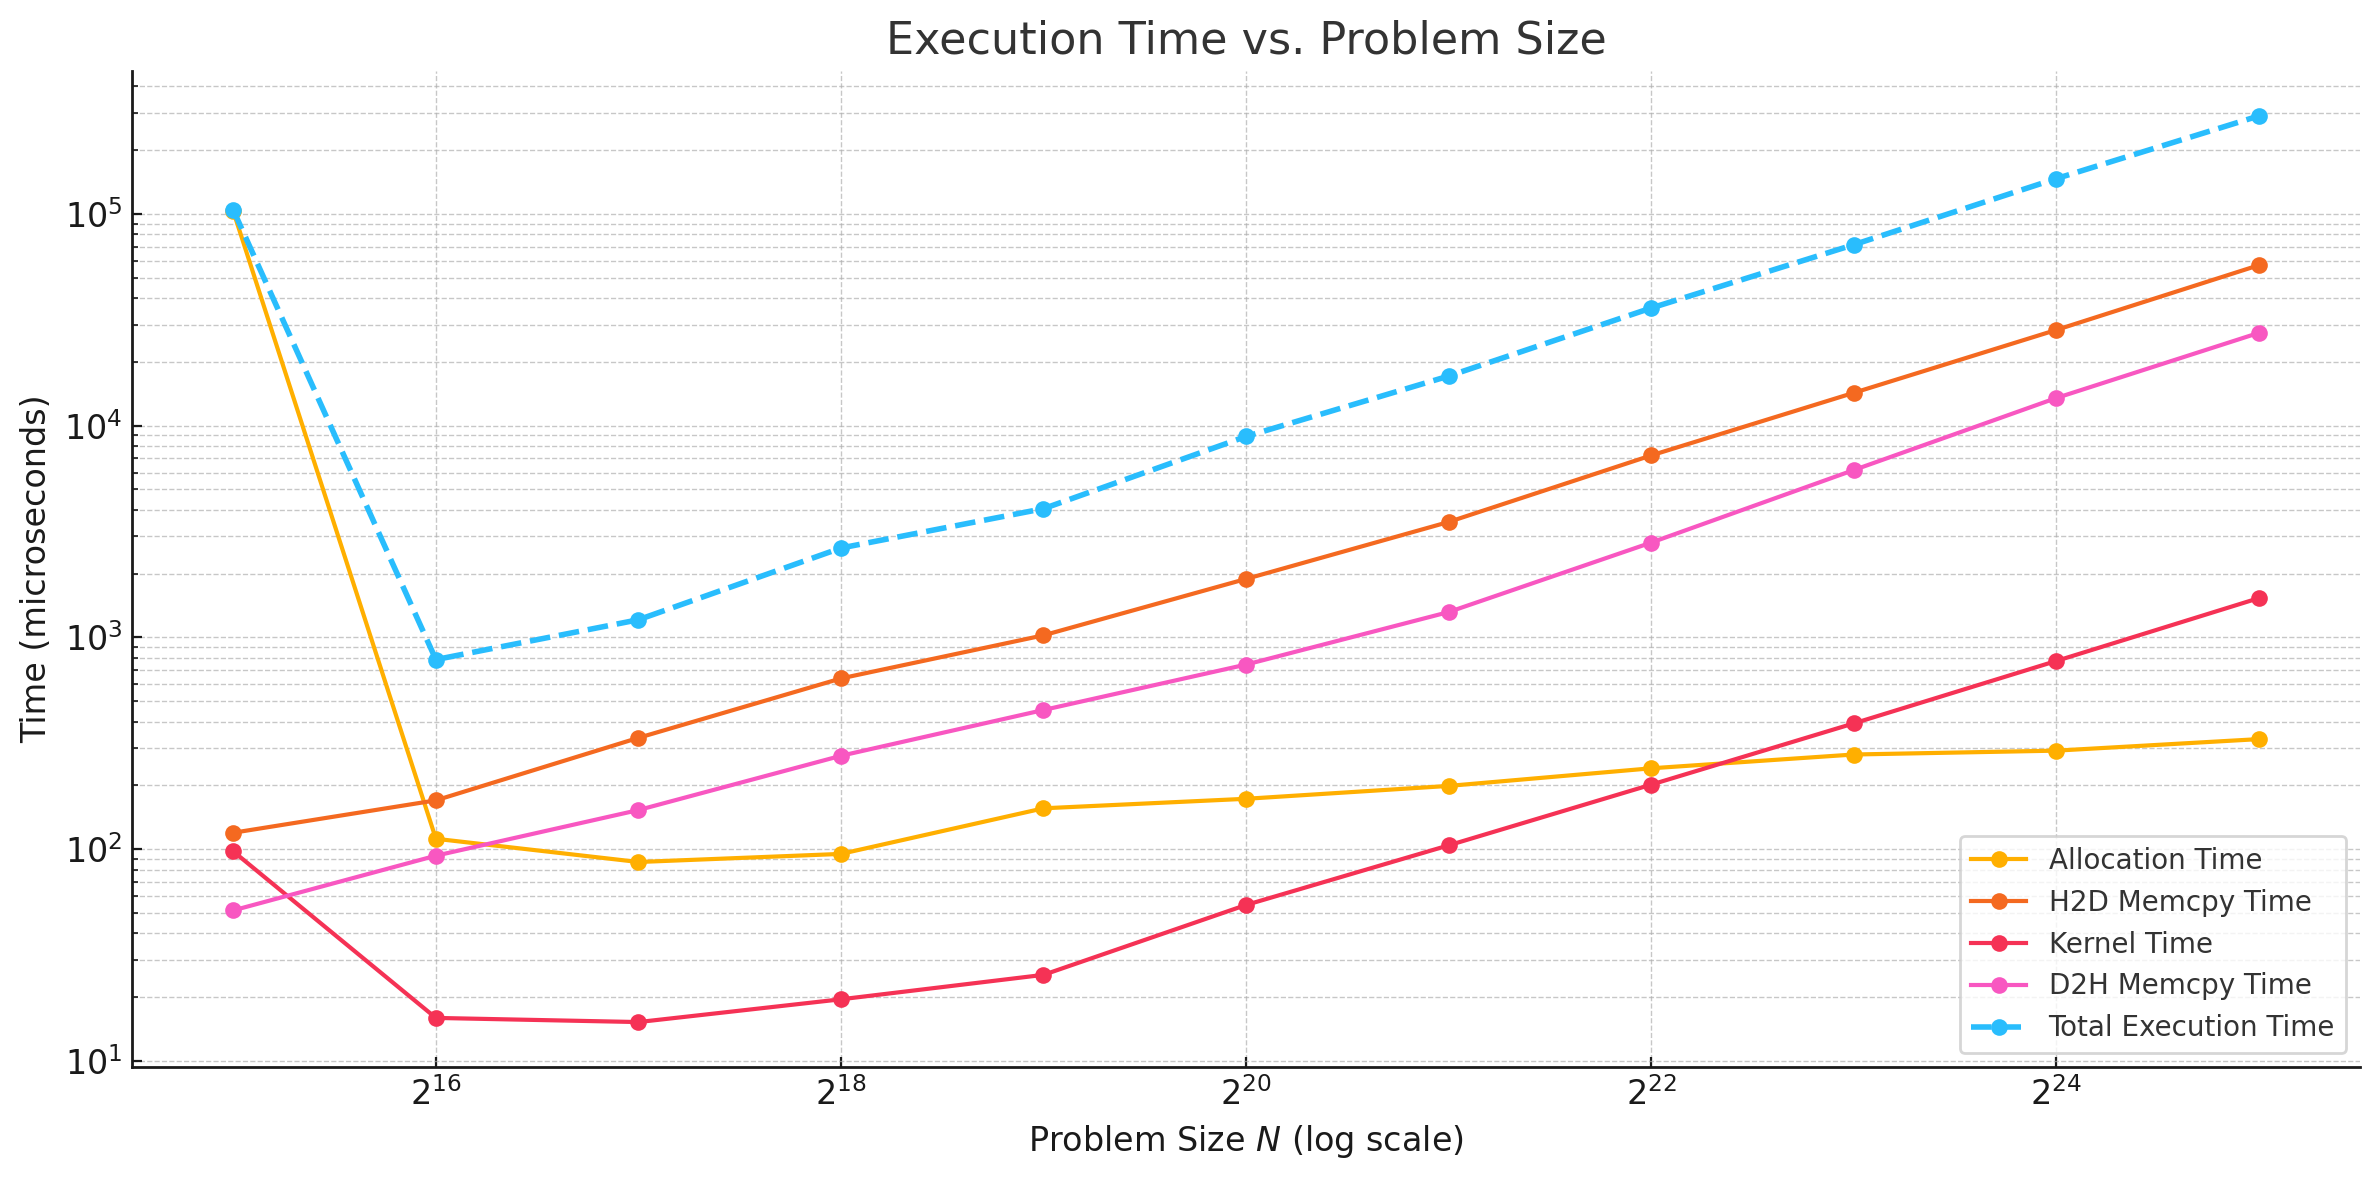

### Kernel Throughput

Measuring kernel efficiency (in ops/μs), now on top of more detailed profiling:

Throughput increases rapidly until about 2^20, then flattens.

Confirms: the GPU is fully saturated and operating near its peak from that point on.

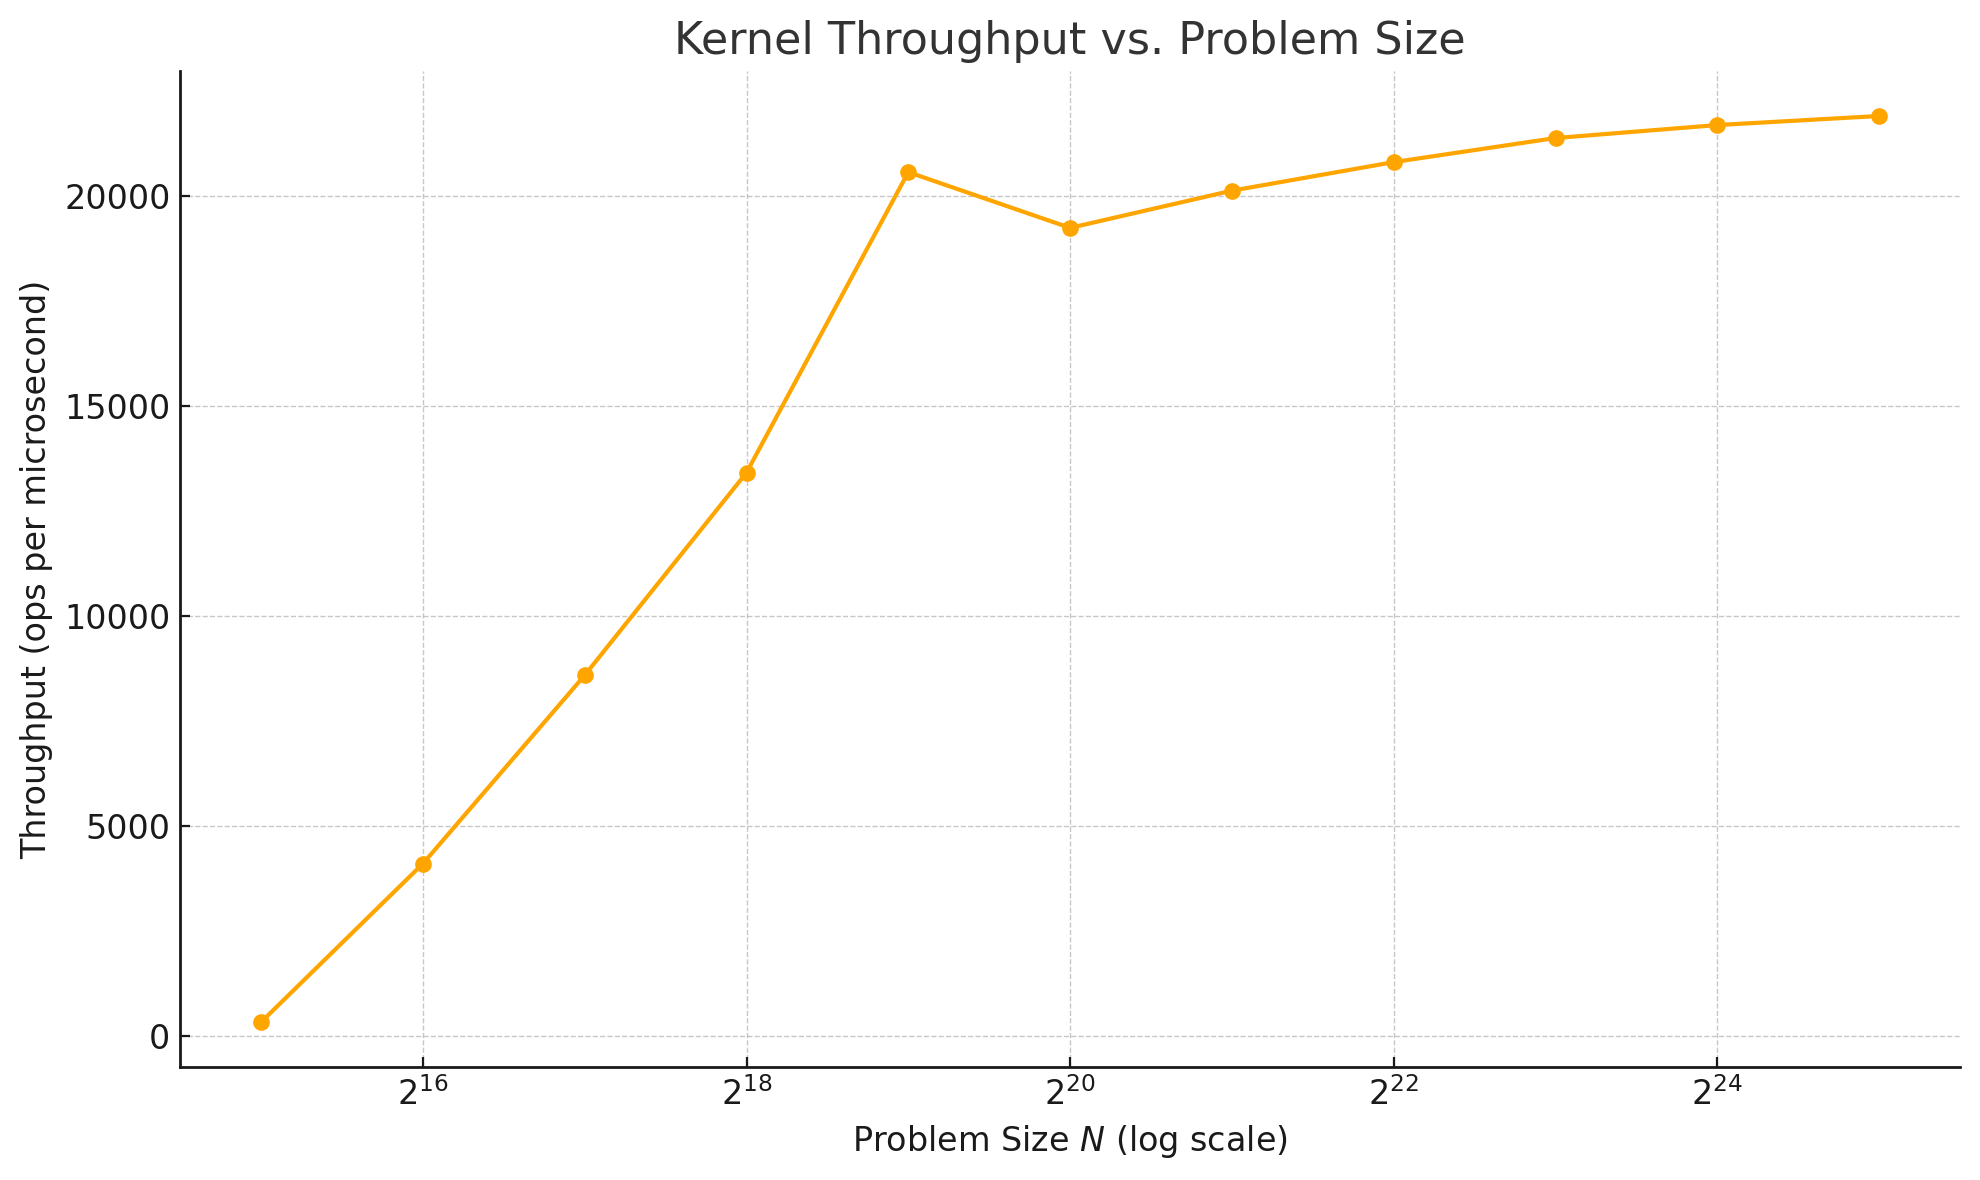

### Observations

- Memory Transfers Dominate at Large Sizes

- Kernel execution grows slowly and smoothly with size.

- Aside from a few early outliers (likely cold-start overhead), allocation time stays small and constant across all sizes.

- The total time is much higher than kernel time alone — so just timing the kernel is misleading.

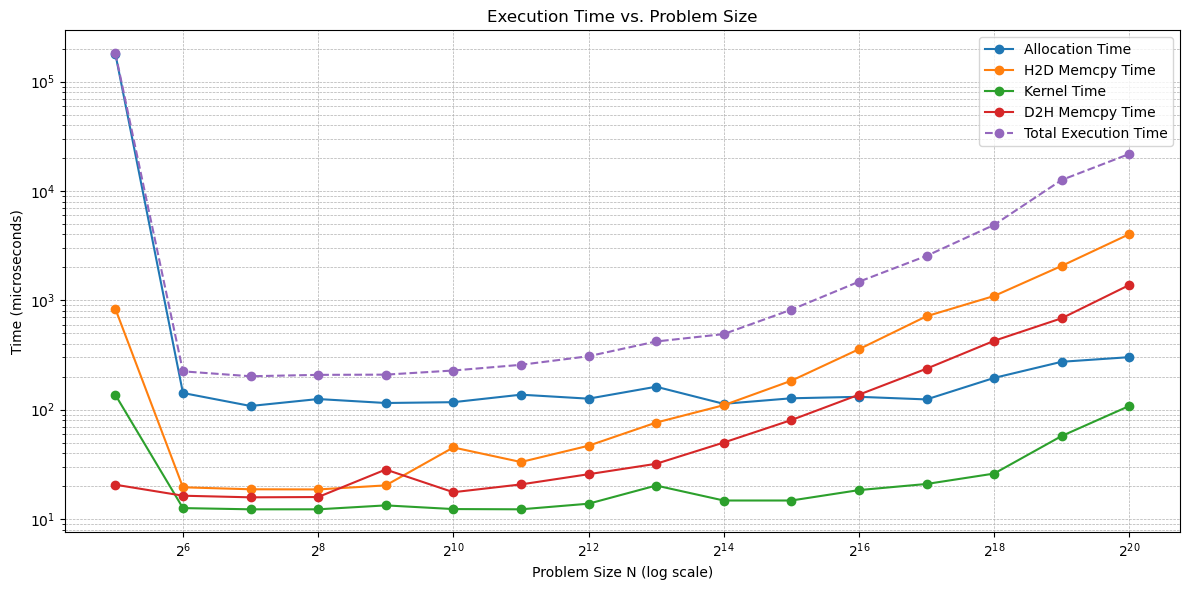

### Additional analysis

I ran the SAXPY program for two additional ranges of N to verify its behavior:

Case 1: N = 2^14 to 2^25

Case 2: N = 2^10 to 2^20

From the analysis, it's clear that the GPU exhibits significant overhead during the initial run (for 2^14 in Case 1 and 2^10 in Case 2). The high initial allocation time suggests that there's overhead in setting up the CUDA memory management system during the first CUDA operations. For subsequent runs, these systems are already initialized, so allocation becomes much faster. For very small problem sizes, this allocation overhead alone can make GPU usage inefficient compared to just using the CPU.

For small problem sizes (below 2^15): The overhead of launching kernels and data transfers becomes disproportionately large and the GPU's parallel processing units remain underutilized.

The results confirms GPU acceleration is most beneficial for computationally intensive tasks with sufficient parallelism to overcome the initialization overhead.

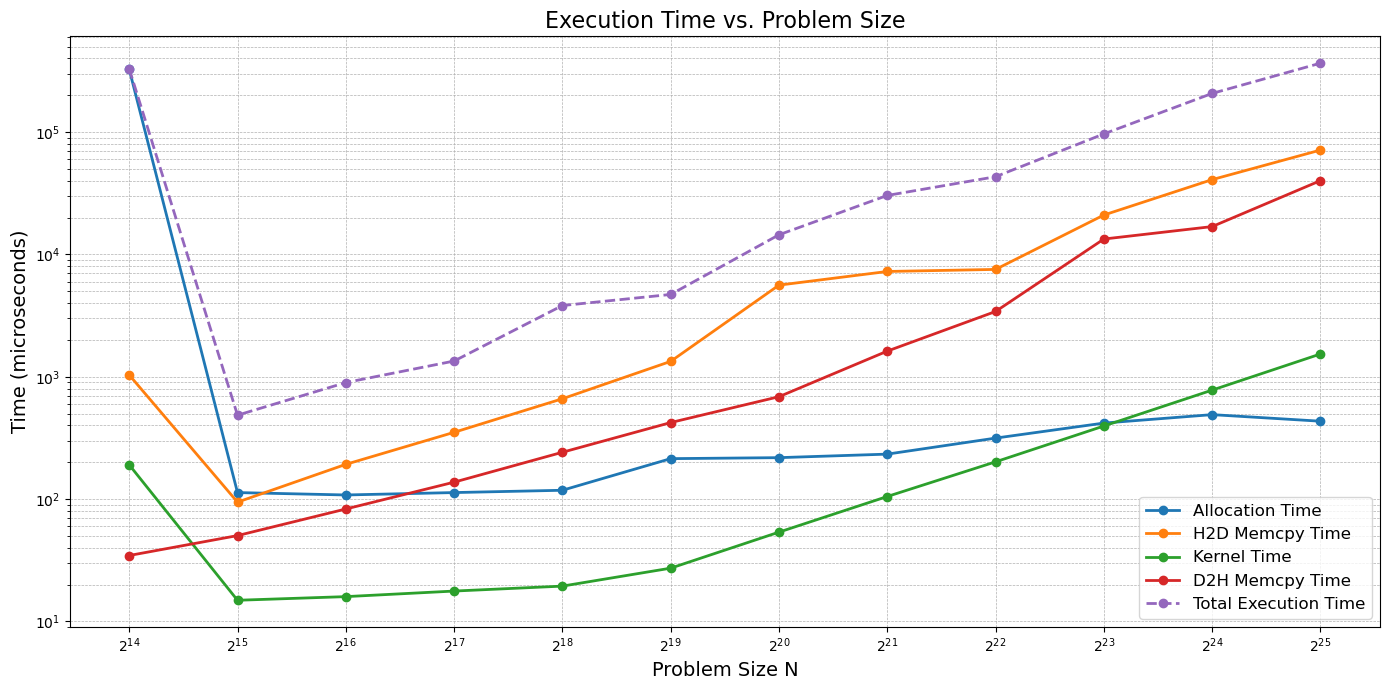
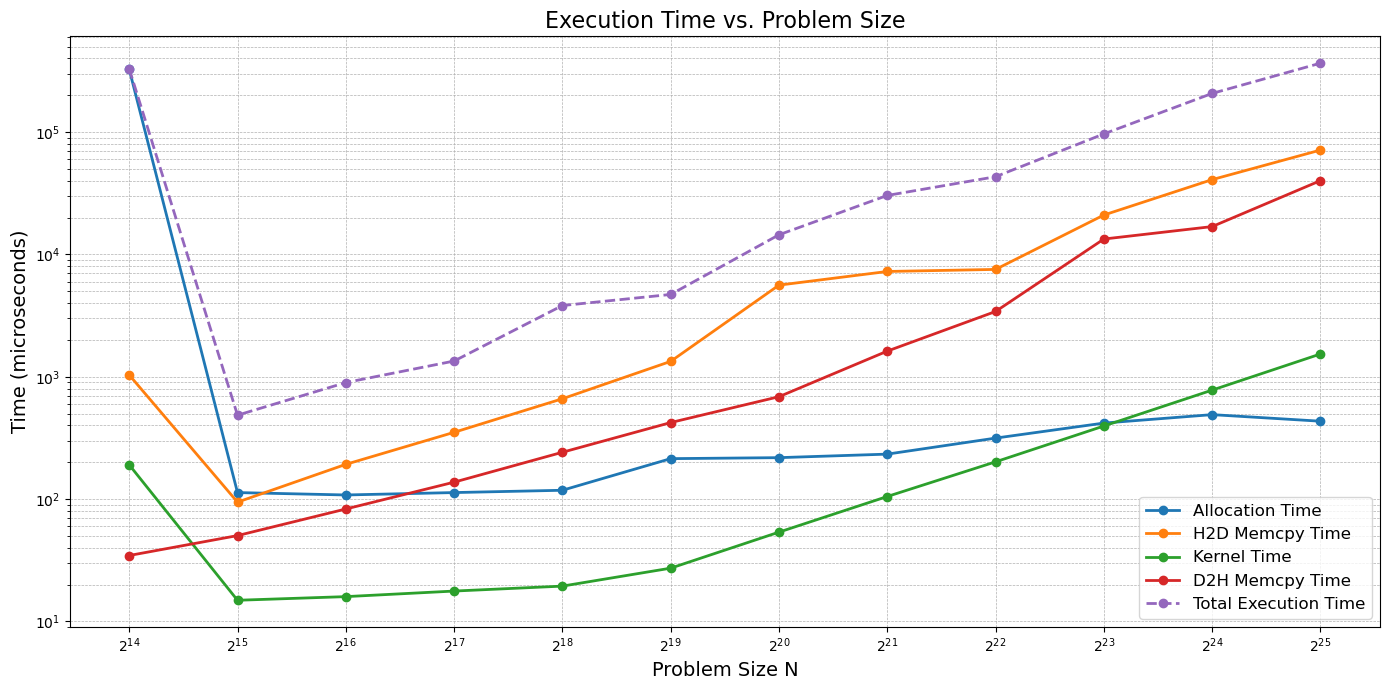